# Adversarial Learned Inference (ALI)

### Imports

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LeakyReLU, Conv2D, RepeatVector, Flatten, Reshape, Lambda, Conv2DTranspose, UpSampling2D, concatenate
from keras import regularizers
from keras.constraints import UnitNorm, MaxNorm

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


## Hyperparams & Options

In [2]:
### DATA SELECTION ###
bkg_filename = "../background_Full_Test3.txt"
sig_filename = "../signal_Full_Test3.txt"
drop_PHI_columns = False
n_train = 25000
scaler = MinMaxScaler()

### OPTIONS ###
savePlots = False
plotsLocation = "./"
AE_train = True
D_train = True
n_d_train = 128
n_p_train = 5000
convDiscriminator = False

### AUTOENCODER ###
encoding_dim = 7
train_steps = 50
ae_epoch = 1
batch_size = 32
leak=0.2
hidden_activation = 'linear'
encoder_activation = 'tanh'
decoder_activation = 'sigmoid'
discriminator_activation = 'sigmoid'
dense_discriminator_hidden = 'relu'

### Data Loading & Preprocessing

In [3]:
bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
coordinate_change(sig_all)
coordinate_change(bkg_all)

if drop_PHI_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)

n_bkg = len(bkg_sel.iloc[:,:0])
n_sig = len(sig_sel.iloc[:,:0])
f_s = n_train/n_sig
f_b = n_train/n_bkg

print ("Number of BACKGROUND events:", n_bkg)
print ("%0.2f%% = %d" % (f_b*100, n_train), "used for TRAINING")
print ("%.2f%% = %d" % (f_b*100, n_train), "used for TESTING")
print ("%05.2f%% = %d" % ((1-2*f_b)*100, n_bkg - 2*n_train), "unused")
print ("Number of SIGNAL events:", n_sig)
print ("%.2f%% = %d" % (f_s*100, n_train), "used for TESTING")
print ("%.2f%% = %d" % ((1-f_s)*100, n_sig - n_train), "unused")
print ("\n")

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:2*n_train], sig_sel.iloc[:n_train]])
sample_test = sample_test.reset_index(drop=True)

input_dim = sample_train.shape[1]

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Training sample size: ',sample_train.shape)
print('Testing sample size: ',sample_test.shape)

sample_train_input, sample_train_valid = train_test_split(sample_train,test_size=0.2,random_state=13)
n_cycle=0
train_time=0

Number of BACKGROUND events: 54194
46.13% = 25000 used for TRAINING
46.13% = 25000 used for TESTING
07.74% = 4194 unused
Number of SIGNAL events: 52766
47.38% = 25000 used for TESTING
52.62% = 27766 unused


Training sample size:  (25000, 13)
Testing sample size:  (50000, 13)


### Generators: Encoder & Decoder
**Note:** The networks *encoder* and *decoder* will not be trained. We define them in order to be used for predictions. Their layers will be included in larger networks where their paramaters will be updated with training

In [4]:
encoder_in = Input(shape=(input_dim,), name='enc_in')
encoder_expand = Dense(128, activation=hidden_activation, name='enc_expand')(encoder_in)
activate_expand= LeakyReLU(alpha=leak)(encoder_expand)
encoder_reshape = Reshape((8,8,2), name='encoder_reshape')(activate_expand)
encoder_c1 = Conv2D(64, kernel_size=3, strides=1, padding="same", name='enc_c1')(encoder_reshape)
activate_ec1 = LeakyReLU(alpha=leak)(encoder_c1)
encoder_c2 = Conv2D(32, kernel_size=3, strides=1, padding="same", name='enc_c2')(activate_ec1)
activate_ec2 = LeakyReLU(alpha=leak)(encoder_c2)
encoder_c3 = Conv2D(16, kernel_size=3, strides=1, padding="same", name='enc_c3')(activate_ec2)
activate_ec3 = LeakyReLU(alpha=leak)(encoder_c3)
encoder_f1 = Flatten()(activate_ec3)
encoder_f2 = Dense(128, activation=hidden_activation, name='enc_f2') (encoder_f1)
activate_ef2 = LeakyReLU(alpha=leak)(encoder_f2)
encoded = Dense(encoding_dim, activation=encoder_activation, name='enc_out')(activate_ef2)

encoder = Model(encoder_in, encoded)
encoder.summary()

decoder_in = Input(shape=(encoding_dim,), name='dec_in')
decoder_f1 = Dense(128, activation=hidden_activation, name='dec_f1')(decoder_in)
activate_df1 = LeakyReLU(alpha=leak)(decoder_f1)
decoder_reshape = Reshape((8,8,2), name='decoder_reshape')(activate_df1)
decoder_c1 = Conv2DTranspose(64, kernel_size=2, strides=1, padding="same", name='dec_c1')(decoder_reshape)
activate_dc1 = LeakyReLU(alpha=leak)(decoder_c1)
decoder_c2 = Conv2DTranspose(32, kernel_size=3, strides=1, padding="same", name='dec_c2')(activate_dc1)
activate_dc2 = LeakyReLU(alpha=leak)(decoder_c2)
decoder_c3 = Conv2DTranspose(16, kernel_size=3, strides=1, padding="same", name='dec_c3')(activate_dc2)
activate_dc3 = LeakyReLU(alpha=leak)(decoder_c3)
decoder_f2 = Flatten()(activate_dc3)
decoder_f3 = Dense(128, activation=hidden_activation, name='dec_f3') (decoder_f2)
activate_df4 = LeakyReLU(alpha=leak)(decoder_f3)
decoded = Dense(input_dim, activation=decoder_activation, name='dec_out')(activate_df4)

decoder = Model(decoder_in, decoded)
decoder.summary()

decoder_layers = decoder.layers[13](decoder.layers[12](decoder.layers[11](decoder.layers[10](decoder.layers[9](
            decoder.layers[8](decoder.layers[7](decoder.layers[6](decoder.layers[5](decoder.layers[4](
            decoder.layers[3](decoder.layers[2](decoder.layers[1](encoded)))))))))))))

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

AE = Model(encoder_in, decoder_layers)
AE.compile(optimizer='adam', loss='mse')
AE.summary()

print(encoder.layers[13])
print(decoder.layers[13])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_in (InputLayer)          (None, 13)                0         
_________________________________________________________________
enc_expand (Dense)           (None, 128)               1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
encoder_reshape (Reshape)    (None, 8, 8, 2)           0         
_________________________________________________________________
enc_c1 (Conv2D)              (None, 8, 8, 64)          1216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
enc_c2 (Conv2D)              (None, 8, 8, 32)          18464     
__________

### Discriminator

In [5]:
if convDiscriminator:
    dis_in_x = Input(shape=(input_dim,), name='discriminator_input_x')
    dis_layers_x = Dense(128, activation=hidden_activation, name='discriminator_hidden_x')(dis_in_x)
    dis_layers_x = LeakyReLU(alpha=leak, name='LeakyReLU_x1')(dis_layers_x)
    dis_layers_x = Reshape((8,8,2), name='discr_reshape_x')(dis_layers_x)
    dis_layers_x = Conv2D(32, kernel_size=3, strides=1, padding="same", name='discr_cx')(dis_layers_x)
    dis_layers_x = LeakyReLU(alpha=leak, name='LeakyReLU_x2')(dis_layers_x)

    dis_in_z = Input(shape=(encoding_dim,), name='discriminator_input_z')
    dis_layers_z = Dense(128, activation=hidden_activation, name='discriminator_hidden_z')(dis_in_z)
    dis_layers_z = LeakyReLU(alpha=leak, name='LeakyReLU_z1')(dis_layers_z)
    dis_layers_z = Reshape((8,8,2), name='discr_reshape_z')(dis_layers_z)
    dis_layers_z = Conv2D(32, kernel_size=3, strides=1, padding="same", name='discr_cz')(dis_layers_z)
    dis_layers_z = LeakyReLU(alpha=leak, name='LeakyReLU_z2')(dis_layers_z)

    dis_in = [dis_in_x, dis_in_z]
    dis_merged = keras.layers.concatenate([dis_layers_x, dis_layers_z], axis=3)
    dis_layers_all = Conv2D(16, kernel_size=3, strides=1, padding="same", name='discr_c')(dis_merged)
    dis_layers_all = LeakyReLU(alpha=leak, name='LeakyReLU_1')(dis_layers_all)
    dis_layers_all = Flatten()(dis_layers_all)
    dis_layers_all = Dense(2, activation=discriminator_activation, name='discriminator_out')(dis_layers_all)
else:
    dis_in_x = Input(shape=(input_dim,), name='discriminator_input_x')
    dis_layers_x = Dense(8, activation=dense_discriminator_hidden, name='discriminator_hidden_x_1')(dis_in_x)
    dis_layers_x = Dense(encoding_dim, activation=dense_discriminator_hidden, name='discriminator_hidden_x_2')(dis_layers_x)

    dis_in_z = Input(shape=(encoding_dim,), name='discriminator_input_z')
    dis_layers_z = Dense(encoding_dim, activation=dense_discriminator_hidden, name='discriminator_hidden_z')(dis_in_z)

    dis_in = [dis_in_x, dis_in_z]
    dis_merged = keras.layers.concatenate([dis_layers_x, dis_layers_z])
    dis_layers_all = Dense(2*encoding_dim, activation=dense_discriminator_hidden, name='discriminator_hidden_all_1')(dis_merged)
    dis_layers_all = Dense(encoding_dim, activation=dense_discriminator_hidden, name='discriminator_hidden_all_2')(dis_layers_all)
    dis_layers_all = Dense(2, activation=discriminator_activation, name='discriminator_output')(dis_layers_all)

discriminator = Model(dis_in, dis_layers_all)


discriminator = Model(dis_in, dis_layers_all)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input_x (InputLay (None, 13)           0                                            
__________________________________________________________________________________________________
discriminator_hidden_x_1 (Dense (None, 8)            112         discriminator_input_x[0][0]      
__________________________________________________________________________________________________
discriminator_input_z (InputLay (None, 7)            0                                            
__________________________________________________________________________________________________
discriminator_hidden_x_2 (Dense (None, 7)            63          discriminator_hidden_x_1[0][0]   
__________________________________________________________________________________________________
discrimina

### Player1: Encoder

In [6]:
p1_in_x = Input(shape=(input_dim,), name='player1_input_x')
p1_in_z = encoder.layers[13](encoder.layers[12](encoder.layers[11](encoder.layers[10](encoder.layers[9](
            encoder.layers[8](encoder.layers[7](encoder.layers[6](encoder.layers[5](encoder.layers[4](
            encoder.layers[3](encoder.layers[2](encoder.layers[1](p1_in_x)))))))))))))

if convDiscriminator:
    p1_score_x = discriminator.layers[10](discriminator.layers[8](
                discriminator.layers[6](discriminator.layers[4](
                    discriminator.layers[2](p1_in_x)))))

    p1_score_z = discriminator.layers[11](discriminator.layers[9](
                discriminator.layers[7](discriminator.layers[5](
                    discriminator.layers[3](p1_in_z)))))

    p1_score = discriminator.layers[16](discriminator.layers[15](discriminator.layers[14](
            discriminator.layers[13](discriminator.layers[12]([p1_score_x, p1_score_z])))))
else:
    p1_score_x = discriminator.layers[3](discriminator.layers[1](p1_in_x))
    p1_score_z = discriminator.layers[4](p1_in_z)
    p1_score_merged = discriminator.layers[6](discriminator.layers[5]([p1_score_x, p1_score_z]))
    p1_score = discriminator.layers[8](discriminator.layers[7](p1_score_merged))

player_1 = Model(p1_in_x, p1_score)

if convDiscriminator:
    player_1.get_layer('discriminator_hidden_x').trainable = False
    player_1.get_layer('discr_cx').trainable = False
    player_1.get_layer('discriminator_hidden_z').trainable = False
    player_1.get_layer('discr_cz').trainable = False
    player_1.get_layer('discr_c').trainable = False
    player_1.get_layer('discriminator_out').trainable = False
else:
    player_1.get_layer('discriminator_hidden_x_1').trainable = False
    player_1.get_layer('discriminator_hidden_x_2').trainable = False
    player_1.get_layer('discriminator_hidden_z').trainable = False
    player_1.get_layer('discriminator_hidden_all_1').trainable = False
    player_1.get_layer('discriminator_hidden_all_2').trainable = False
    player_1.get_layer('discriminator_output').trainable = False

player_1.compile(optimizer='adam', loss='binary_crossentropy')
player_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player1_input_x (InputLayer)    (None, 13)           0                                            
__________________________________________________________________________________________________
enc_expand (Dense)              (None, 128)          1792        player1_input_x[0][0]            
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128)          0           enc_expand[1][0]                 
__________________________________________________________________________________________________
encoder_reshape (Reshape)       (None, 8, 8, 2)      0           leaky_re_lu_1[1][0]              
__________________________________________________________________________________________________
enc_c1 (Co

### Player2: Decoder

In [7]:
p2_in_z = Input(shape=(encoding_dim,), name='player2_input_z')
p2_in_x = decoder.layers[13](decoder.layers[12](decoder.layers[11](decoder.layers[10](decoder.layers[9](
            decoder.layers[8](decoder.layers[7](decoder.layers[6](decoder.layers[5](decoder.layers[4](
            decoder.layers[3](decoder.layers[2](decoder.layers[1](p2_in_z)))))))))))))

if convDiscriminator:
    p2_score_x = discriminator.layers[10](discriminator.layers[8](
                discriminator.layers[6](discriminator.layers[4](
                    discriminator.layers[2](p2_in_x)))))

    p2_score_z = discriminator.layers[11](discriminator.layers[9](
                discriminator.layers[7](discriminator.layers[5](
                    discriminator.layers[3](p2_in_z)))))

    p2_score = discriminator.layers[16](discriminator.layers[15](discriminator.layers[14](
            discriminator.layers[13](discriminator.layers[12]([p2_score_x, p2_score_z])))))
else:
    p2_score_x = discriminator.layers[3](discriminator.layers[1](p2_in_x))
    p2_score_z = discriminator.layers[4](p2_in_z)
    p2_score_merged = discriminator.layers[6](discriminator.layers[5]([p2_score_x, p2_score_z]))
    p2_score = discriminator.layers[8](discriminator.layers[7](p2_score_merged))
    
player_2 = Model(p2_in_z, p2_score)

if convDiscriminator:
    player_2.get_layer('discriminator_hidden_x').trainable = False
    player_2.get_layer('discr_cx').trainable = False
    player_2.get_layer('discriminator_hidden_z').trainable = False
    player_2.get_layer('discr_cz').trainable = False
    player_2.get_layer('discr_c').trainable = False
    player_2.get_layer('discriminator_out').trainable = False
else:
    player_2.get_layer('discriminator_hidden_x_1').trainable = False
    player_2.get_layer('discriminator_hidden_x_2').trainable = False
    player_2.get_layer('discriminator_hidden_z').trainable = False
    player_2.get_layer('discriminator_hidden_all_1').trainable = False
    player_2.get_layer('discriminator_hidden_all_2').trainable = False
    player_2.get_layer('discriminator_output').trainable = False

player_2.compile(optimizer='adam', loss='binary_crossentropy')
player_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player2_input_z (InputLayer)    (None, 7)            0                                            
__________________________________________________________________________________________________
dec_f1 (Dense)                  (None, 128)          1024        player2_input_z[0][0]            
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 128)          0           dec_f1[2][0]                     
__________________________________________________________________________________________________
decoder_reshape (Reshape)       (None, 8, 8, 2)      0           leaky_re_lu_6[2][0]              
__________________________________________________________________________________________________
dec_c1 (Co

### Training

In [8]:
discriminator_history = np.empty(train_steps)
ae_mse = np.empty(train_steps)
game_history = np.empty([train_steps,2])


AEhistory = LossHistory()
Dhistory = LossHistory()
P2history = LossHistory()
P1history = LossHistory()
    
gradient_ascent=-np.ones(batch_size)

start = time.time()

with tf.device('/GPU:0'):
    for i in range(train_steps):
            #discriminator
            if D_train:
                y_dec = np.tile([1,0], [n_d_train,1])
                y_enc = np.tile([0,1], [n_d_train,1])
                x_sample = sample_train[np.random.randint(0,sample_train.shape[0], size=n_d_train)]
                encoded_z = encoder.predict(x_sample)
                z_sample = np.random.uniform(0, 1.0, size=[n_d_train, encoding_dim])
                decoded_x = decoder.predict(z_sample)
                #xz_enc = [x_sample, encoded_z]            
                #xz_dec = [decoded_x, z_sample]
                x = np.concatenate([x_sample,decoded_x])
                z = np.concatenate([encoded_z,z_sample])
                xz = [x,z]
                true = np.concatenate([y_enc,y_dec])
                Dtrain = discriminator.fit(xz, true,
                    epochs=ae_epoch,
                    batch_size=32,
                    shuffle=True,
                    callbacks=[Dhistory])
                discriminator_history[i]=Dtrain.history['loss'][0]
         
            #AE
            x_sample = sample_train[np.random.randint(0,sample_train.shape[0], size=n_p_train)]
            z_sample = np.random.uniform(0, 1.0, size=[n_p_train, encoding_dim])
            y_dec = np.tile([1,0], [n_p_train,1])
            y_enc = np.tile([0,1], [n_p_train,1])
            P2train=player_2.fit(z_sample, y_enc, 
                    epochs=ae_epoch,
                    batch_size=32,
                    shuffle=True,
                    callbacks=[P2history])
            P1train=player_1.fit(x_sample, y_dec, 
                    epochs=ae_epoch,
                    batch_size=32,
                    shuffle=True,
                    callbacks=[P2history])
            game_history[i] = [P1train.history['loss'][0], P2train.history['loss'][0]]    
            
            if AE_train:
                AEtrain = AE.fit(sample_train_input, sample_train_input,
                    epochs=ae_epoch,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(sample_train_valid, sample_train_valid),
                    callbacks=[AEhistory])
                ae_mse[i]=AEtrain.history['loss'][0]

            
            #progress report
            prc = ((i+1)/train_steps)*100
            print('\n')
            print(" - - - - - - - - - = = = = = | %.2f %% COMPLETED | = = = = = - - - - - - - - -" % prc)
            print('\n')
            
end = time.time()
train_time += (end-start)
n_cycle += 1

/home/ioan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
256/256 [==============================] - 0s 1ms/step - loss: 0.6905
Epoch 1/1
5000/5000 [==============================] - 1s 222us/step - loss: 0.6191
Epoch 1/1
5000/5000 [==============================] - 1s 206us/step - loss: 0.4348
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 5s 227us/step - loss: 1.0310 - val_loss: 1.0302


 - - - - - - - - - = = = = = | 2.00 % COMPLETED | = = = = = - - - - - - - - -


Epoch 1/1
256/256 [==============================] - 0s 136us/step - loss: 0.9136
Epoch 1/1
5000/5000 [==============================] - 1s 118us/step - loss: 0.6278
Epoch 1/1
5000/5000 [==============================] - 1s 109us/step - loss: 0.4765
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 4s 224us/step - loss: 1.0310 - val_loss: 1.0302


 - - - - - - - - - = = = = = | 4.00 % COMPLETED | = = = = = - - - - - - - - -


Epoch 1/1
256/256 [===========

256/256 [==============================] - 0s 98us/step - loss: 0.3410
Epoch 1/1
5000/5000 [==============================] - 1s 152us/step - loss: 1.2005
Epoch 1/1
5000/5000 [==============================] - 1s 198us/step - loss: 1.5223
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 5s 255us/step - loss: 1.0310 - val_loss: 1.0302


 - - - - - - - - - = = = = = | 36.00 % COMPLETED | = = = = = - - - - - - - - -


Epoch 1/1
256/256 [==============================] - 0s 86us/step - loss: 0.2962
Epoch 1/1
5000/5000 [==============================] - 1s 140us/step - loss: 1.3359
Epoch 1/1
5000/5000 [==============================] - 1s 213us/step - loss: 1.6683
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 4s 219us/step - loss: 1.0310 - val_loss: 1.0302


 - - - - - - - - - = = = = = | 38.00 % COMPLETED | = = = = = - - - - - - - - -


Epoch 1/1
256/256 [===================

256/256 [==============================] - 0s 243us/step - loss: 0.0204
Epoch 1/1
5000/5000 [==============================] - 1s 218us/step - loss: 4.4220
Epoch 1/1
5000/5000 [==============================] - 1s 221us/step - loss: 4.0679
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 7s 360us/step - loss: 1.0310 - val_loss: 1.0302


 - - - - - - - - - = = = = = | 70.00 % COMPLETED | = = = = = - - - - - - - - -


Epoch 1/1
256/256 [==============================] - 0s 196us/step - loss: 0.0177
Epoch 1/1
5000/5000 [==============================] - 1s 286us/step - loss: 4.5708
Epoch 1/1
5000/5000 [==============================] - 1s 192us/step - loss: 4.1668
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 6s 285us/step - loss: 1.0310 - val_loss: 1.0302


 - - - - - - - - - = = = = = | 72.00 % COMPLETED | = = = = = - - - - - - - - -


Epoch 1/1
256/256 [=================

### Training Loss

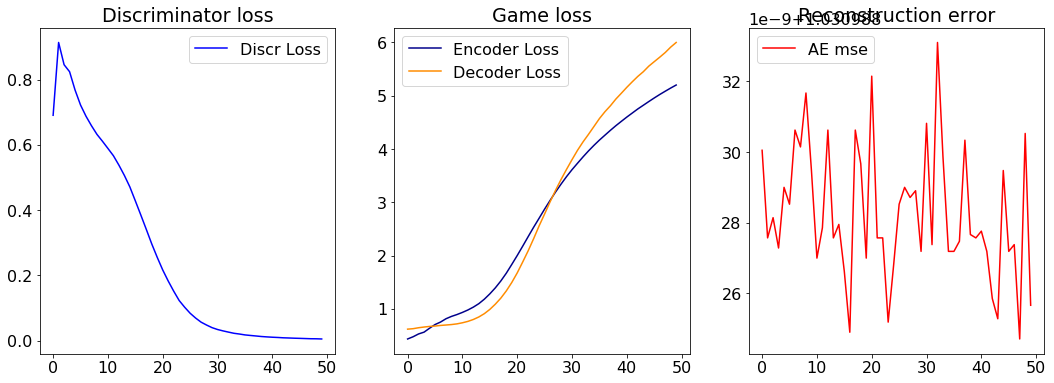

In [9]:
epochs = range(train_steps)
file_name = "%dcylce" % (n_cycle)
plt.rcParams.update({'font.size': 16})

if D_train and AE_train:
    lossFig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, discriminator_history[:], 'b', label='Discr Loss')
    plt.title('Discriminator loss')
    plt.legend(loc="best")
    plt.subplot(1, 3, 2)
    plt.plot(epochs, game_history[:,0], 'darkblue', label='Encoder Loss')
    plt.plot(epochs, game_history[:,1], 'darkorange', label='Decoder Loss')
    plt.title('Game loss')
    plt.legend(loc="best")
    plt.subplot(1, 3, 3)
    plt.plot(epochs, ae_mse[:], 'r', label='AE mse')
    plt.title('Reconstruction error')
    plt.legend(loc="best")
    plt.show()
    
elif D_train:
    lossFig = plt.figure(figsize=(18, 9))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, discriminator_history[:], 'b', label='Discr Loss')
    plt.title('Discriminator loss')
    plt.legend(loc="best")
    plt.subplot(1, 2, 2)
    plt.plot(epochs, game_history[:,0], 'darkblue', label='Encoder Loss')
    plt.plot(epochs, game_history[:,1], 'darkorange', label='Decoder Loss')
    plt.title('Game loss')
    plt.legend(loc="best")

elif AE_train:
    lossFig = plt.figure(figsize=(8, 8))
    plt.plot(epochs, ae_mse[:], 'r', label='AE mse')
    plt.title('Reconstruction error')
    plt.legend(loc="best")
    plt.show()



if savePlots:
    lossFig.savefig(plotsLocation + file_name + "Loss.png")

### Figure of merit

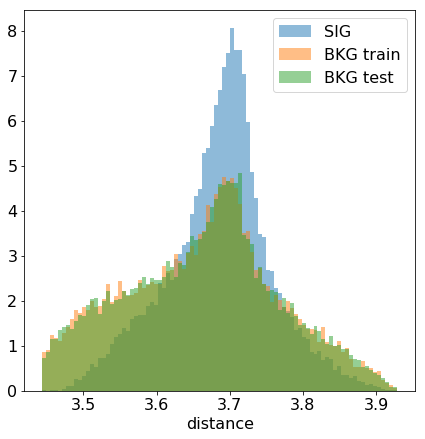

In [10]:
# on test data
encoded_imgs = encoder.predict(sample_test)
decoded_imgs = decoder.predict(encoded_imgs)

# on train data
encoded_imgs_train = encoder.predict(sample_train)
decoded_imgs_train = decoder.predict(encoded_imgs_train)

norm_bkg_test=[]
for i in range(sample_test.shape[0]//2):
    norm_bkg_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]
    
norm_sig=[]
for i in range(sample_test.shape[0]//2, sample_test.shape[0]):
    norm_sig += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_bkg_train=[]
for i in range(sample_train.shape[0]):
    norm_bkg_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]

plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_sig, bins='auto', alpha=0.5, label='SIG', density=True)
plt.hist(norm_bkg_train, bins, alpha=0.5, label='BKG train', density=True)
plt.hist(norm_bkg_test, bins, alpha=0.5, label='BKG test', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')

if savePlots:
    plt.savefig(plotsLocation + "distances.png")

### Encoding variable distributions

/home/ioan/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ioan/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


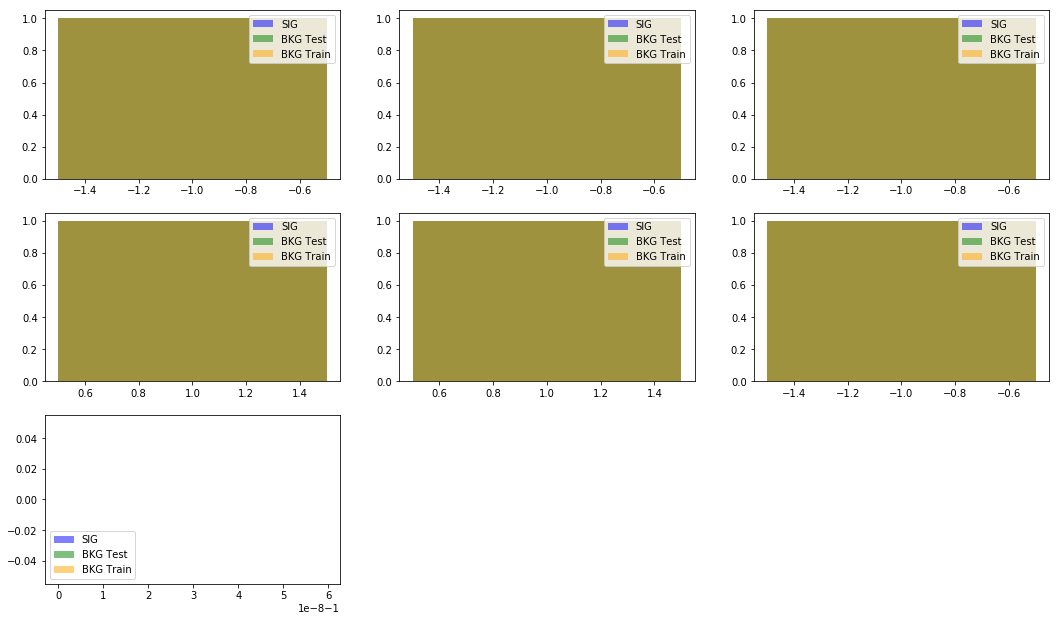

In [11]:
encoded_train = encoded_imgs_train
encoded_bkg = encoded_imgs[:sample_train.shape[0],]
encoded_sig = encoded_imgs[sample_train.shape[0]:sample_test.shape[0],]

plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(18, 18))
for i in range(encoding_dim):
    plt.subplot(5, 3, i+1)
    n, bins, patches=plt.hist(encoded_sig[:,i], bins='auto', alpha=0.5, label='SIG', color='blue', density=True)
    n, bins, patches=plt.hist(encoded_bkg[:,i], bins='auto', alpha=0.5, label='BKG Test', color='green',  density=True)
    n, bins, patches=plt.hist(encoded_train[:,i], bins='auto', alpha=0.5, label='BKG Train', color='orange', density=True)
    plt.legend(loc='best')
plt.show()

### ROC

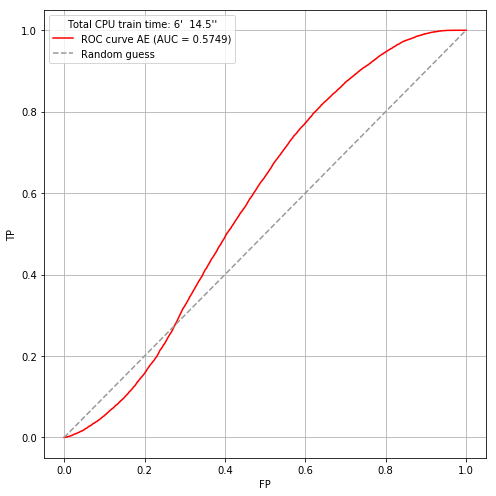

In [12]:
target = np.concatenate((np.zeros(sample_train.shape[0] + sample_test.shape[0]//2),np.ones(n_train)))
scores = np.concatenate((norm_bkg_train,norm_bkg_test, norm_sig))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))
plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1], linestyle='--',color=(0.6, 0.6, 0.6), label='Random guess')
plt.grid()
plt.legend(loc="best", title =time_stamp)
plt.tight_layout()

if savePlots:
    plt.savefig(plotLocation + "ROC.png")

### Reconstructions

##### Training data

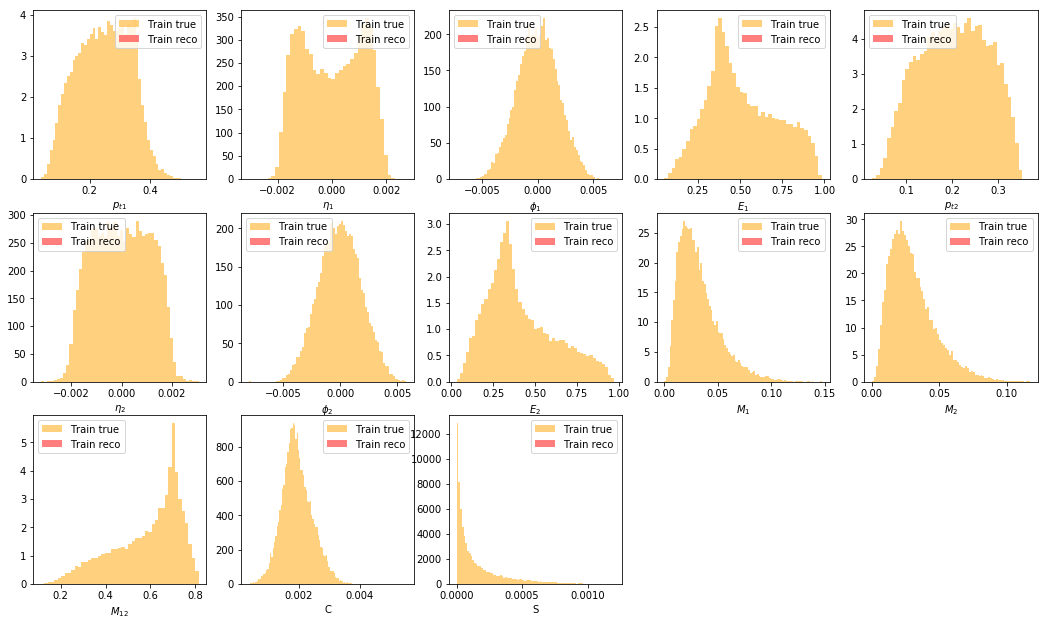

In [13]:
plt.figure(figsize=(18, 18))
plt.rcParams.update({'font.size': 10})
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches=plt.hist(sample_train[:,i], bins='auto', alpha=0.5, label='Train true',color='orange', density=True)
    plt.hist(decoded_imgs_train[:,i], bins=bins, alpha=0.5, label='Train reco',color='red' , density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')

##### New Background

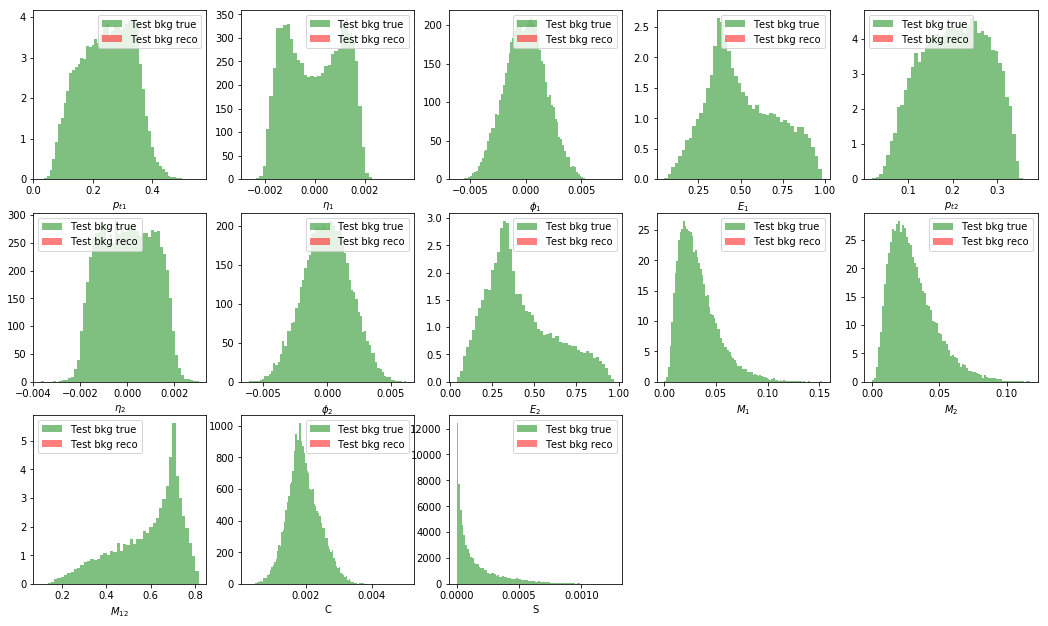

In [14]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[:sample_test.shape[0]//2,i], bins='auto', alpha=0.5, label='Test bkg true', color='green', density=True)
    n, bins, patches = plt.hist(decoded_imgs[:sample_test.shape[0]//2,i], bins, alpha=0.5, label='Test bkg reco', color='red', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')
    

#####  Signal

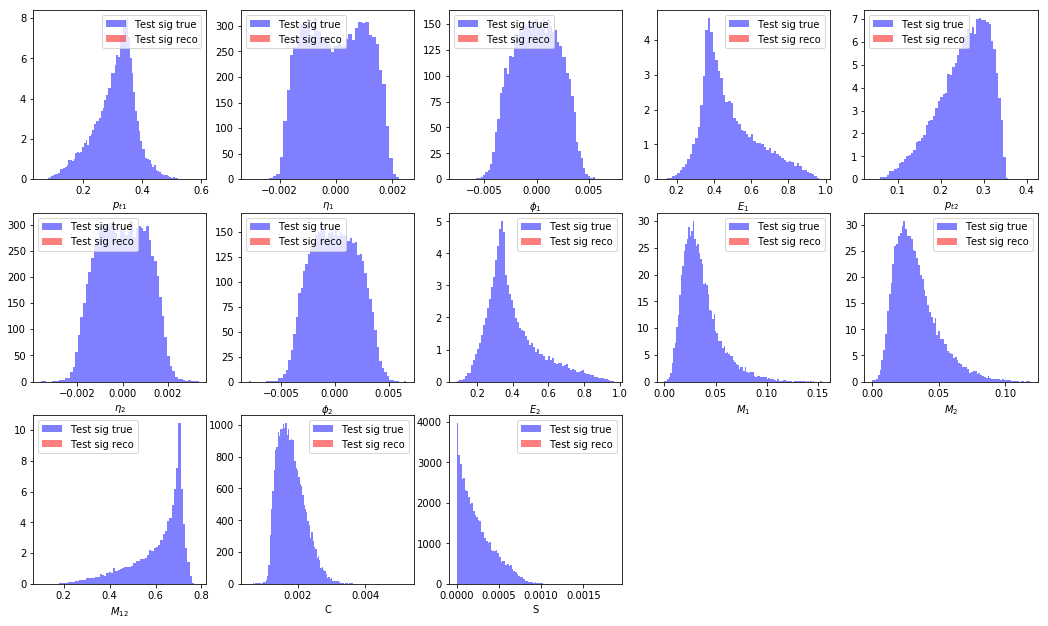

In [15]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[sample_test.shape[0]//2:sample_test.shape[0],i], bins='auto', alpha=0.5, label='Test sig true', color='blue', density=True)
    n, bins, patches = plt.hist(decoded_imgs[sample_test.shape[0]//2:sample_test.shape[0],i], bins, alpha=0.5, label='Test sig reco', color='red', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')